# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> The Kullback-Leibler divergence between $p_{\theta}$ and $p_D$ is defined as : $$D_{KL}(p_{\theta}||p_D) = \mathbb{E}_{X \sim p_D}[-log(\frac{p_{\theta}}{p_D})] = -\mathbb{E}_{X \sim p_D}[log(p_{\theta}]-H(p_D)$$

 
 

> The Earth Mover distance (EMD) is the minimum solution of an optimization problem which can be solved as a transportation problem. The problem is to transform distribution $p_{\theta}$ in $p_D$ with minimum work done. The optimal flow between the two distribution is the minimum of $EMD(p_{\theta},p_D)$ 

> The Maximum Mean Discrepancy (MMD) is the distance between feature means.
 



Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> First, if the dimension is large, the density is not tractable. Then we can only compute expectations with an empirical approximation. We would like to build a distribution with low variance if we want the expectation to represent the distribution. Last but not least,  the loss function has to be smooth to be optimized.

> In this problem, we only have access to sample. Therefore we cannot use KL divergence.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> The larger N is, the more variability there is in the generated distribution. N is the dimension of the latent space, therefore it is an important parameter.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

> The Jensen–Shannon divergence, a symmetrized and smoothed
version of the Kullback–Leibler divergence, is upper bounded by $JSD(p_\theta \| p_D) < \log(2)$. 

> If the two distributions are totally different, the divergence is at it's maximum. The discriminator loss $\mathcal{L}_D \sim 0$ is small and the discriminator is perfectly able to tell the difference between generated and true samples. Then, the loss of the generator  $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) \sim 0$ will be small as $D(x) \sim 0$ if 
x was generated with $p_{\theta}$. 

> This will lead to vanishing gradients, a poor and slow training.


**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> First, this loss doesn't measure diversity, which mean that the generator could produce the same sample multiple times. Then, this feedback depends a lot on the discriminator performance. If the discriminator is too good, the generator won't have enough information to improve, and we will meet the vanishing gradient problem described in the previous question. On the other hand, if the discriminator is really bad, the generator won't learn either. 

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [ ]:
import torch
import math
from sklearn import datasets
import numpy as np
import pandas as pd

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data).to(device)

Let's plot a large batch, to see what the dataset looks like.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0].cpu(), batch[:,1].cpu(), s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self, d=3, w=128):
        super().__init__()
        self.depth = d
        self.width = w
        self.fc1 = nn.Linear(PRIOR_N, w)
        self.fc_hid = nn.ModuleList()
        for _ in range(self.depth-2):
            self.fc_hid.append(nn.Linear(w, w))
        self.fc2 = nn.Linear(w, 2)

    def __call__(self, z):
        h = F.relu(self.fc1(z))
        for i in range(self.depth-2):
          h = F.relu(self.fc_hid[i](h))
        return self.fc2(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        z = z.to(device)
        return self.__call__(z)
 

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, d=3, w=32):
        super().__init__()
        self.depth = d
        self.width = w
        self.fc1 = nn.Linear(2, w)
        self.fc_hid = nn.ModuleList()
        for _ in range(self.depth-2):
            self.fc_hid.append(nn.Linear(w, w))
        self.fc2 = nn.Linear(w, 1)
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        for i in range(self.depth-2):
          h = F.relu(self.fc_hid[i](h))
        return self.fc2(h)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [ ]:
def print_results(generator, discriminator, gen_loss, dis_loss):
  print("\n\n __________________")
  print("Generator :", generator, "Depth ", generator.depth, "Width", generator.width)
  print("Discriminator", discriminator, "Depth ", discriminator.depth, "Width", discriminator.width)
  print('Loss at final Step : discriminator: {:.3e}, generator: {:.3e}'.format( float(dis_loss[-1]), float(gen_loss[-1])))

  real_batch = generate_batch(1024)
  fake_batch = generator.generate(1024).detach()

  fig = plt.figure(figsize=(20,5))
  ax = fig.add_subplot(1,3,1)
  ax.scatter(real_batch[:,0].cpu(), real_batch[:,1].cpu(), s=2.0, label='real data')
  ax.scatter(fake_batch[:,0].cpu(), fake_batch[:,1].cpu(), s=2.0, label='fake data')
  ax.legend()
  ax = fig.add_subplot(1, 3, 2)
  ax.plot(pd.Series(gen_loss).rolling(window=1000).mean())
  ax.set_title('Generator Loss')
  ax = fig.add_subplot(1, 3, 3)
  ax.plot(pd.Series(dis_loss).rolling(window=1000).mean())
  ax.set_title('Discriminator Loss')
  plt.show()

step 0: discriminator: 1.390e+00, generator: 7.891e-01


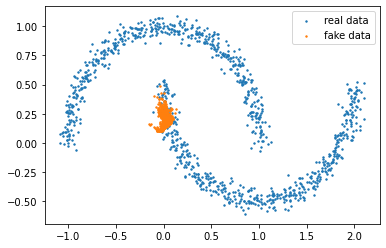

step 1000: discriminator: 1.375e+00, generator: 6.855e-01


step 2000: discriminator: 1.365e+00, generator: 7.223e-01


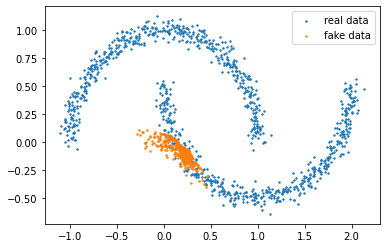

step 3000: discriminator: 1.385e+00, generator: 6.754e-01


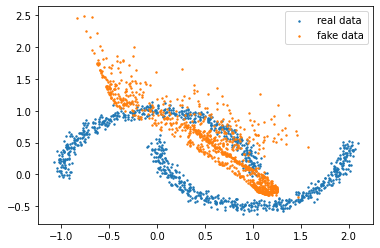

step 4000: discriminator: 1.386e+00, generator: 6.728e-01


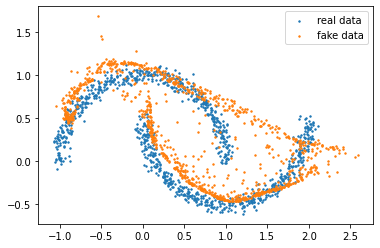

step 5000: discriminator: 1.386e+00, generator: 6.982e-01


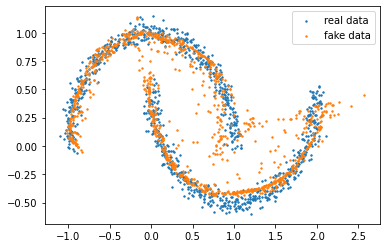

step 6000: discriminator: 1.390e+00, generator: 6.938e-01


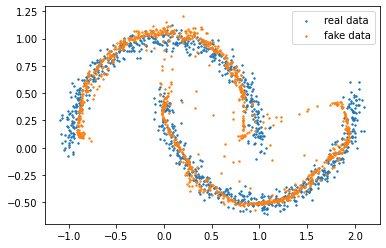

step 7000: discriminator: 1.388e+00, generator: 6.845e-01


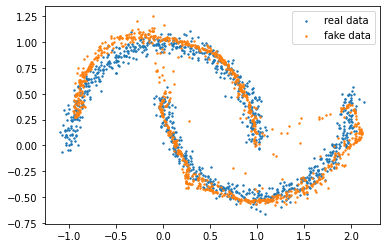

step 8000: discriminator: 1.386e+00, generator: 7.071e-01


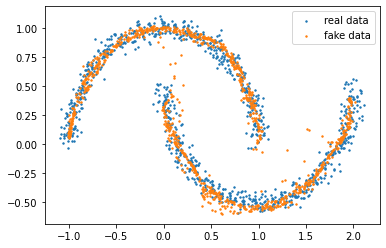

step 9000: discriminator: 1.383e+00, generator: 7.029e-01


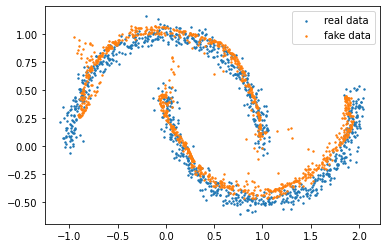

step 10000: discriminator: 1.387e+00, generator: 6.925e-01


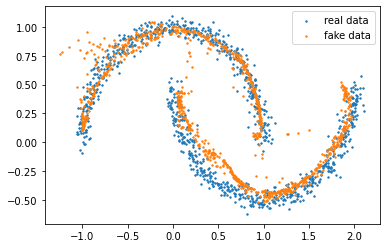

step 11000: discriminator: 1.387e+00, generator: 7.084e-01


step 12000: discriminator: 1.386e+00, generator: 6.817e-01


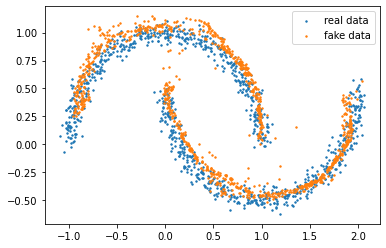

step 13000: discriminator: 1.386e+00, generator: 6.764e-01


step 14000: discriminator: 1.386e+00, generator: 6.783e-01


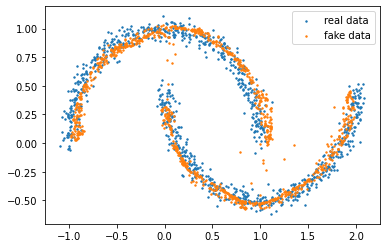

step 15000: discriminator: 1.386e+00, generator: 7.052e-01


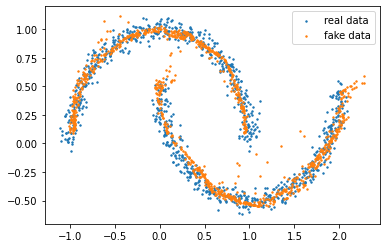

step 16000: discriminator: 1.386e+00, generator: 6.856e-01


step 17000: discriminator: 1.386e+00, generator: 6.874e-01


step 18000: discriminator: 1.386e+00, generator: 7.029e-01


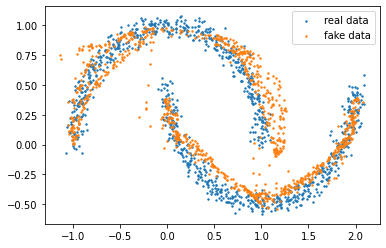

step 19000: discriminator: 1.388e+00, generator: 6.970e-01


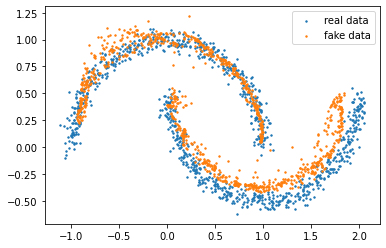

step 20000: discriminator: 1.387e+00, generator: 7.024e-01




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc2): Linear(in_features=32, out_features=1, bias=True)
) Depth  3 Width 32
Loss at final Step : discriminator: 6.992e-01, generator: 1.386e+00


In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20005
# Batch size to use
BATCHLEN = 128

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)


def train(TRAIN_R, discriminator, generator, plot=False):
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
    list_gen_loss = []
    list_disc_loss = []
    for i in range(N_ITER):
        # train the discriminator
        for _ in range(TRAIN_R):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)
            #
            # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
            #
            disc_loss = torch.mean(F.softplus(-discriminator(real_batch)) + F.softplus(discriminator(fake_batch)))
            list_disc_loss.append(disc_loss.cpu().detach().numpy())
            disc_loss.backward()
            optim_disc.step()
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE GENERATOR LOSS HERE
        #
        gen_loss = torch.mean(F.softplus(-discriminator(fake_batch)))
        list_gen_loss.append(gen_loss.cpu().detach().numpy())
        gen_loss.backward()
        optim_gen.step()
        if plot:
            if i%1000 == 0:
                print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
                # plot the result
                real_batch = generate_batch(1024)
                fake_batch = generator.generate(1024).detach()
                plt.scatter(real_batch[:,0].cpu(), real_batch[:,1].cpu(), s=2.0, label='real data')
                plt.scatter(fake_batch[:,0].cpu(), fake_batch[:,1].cpu(), s=2.0, label='fake data')
                plt.legend()
                plt.show()
    return list_disc_loss, list_gen_loss

gen_loss, dis_loss = train(TRAIN_RATIO, discriminator, generator, plot=True)
print_results(generator, discriminator, gen_loss, dis_loss)

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

>  $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is concave, thus this function is hard to minimize. It would be easier to change for a convex function.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc_hid): ModuleList()
  (fc2): Linear(in_features=4, out_features=2, bias=True)
) Depth  2 Width 4
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 1.380e+00, generator: 9.084e-01


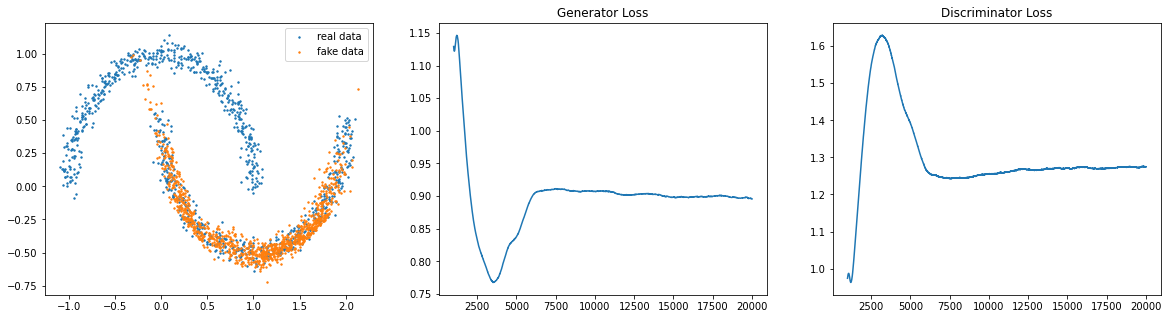



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList()
  (fc2): Linear(in_features=16, out_features=2, bias=True)
) Depth  2 Width 16
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 7.458e-01, generator: 1.249e+00




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
) Depth  2 Width 64
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.725e-01, generator: 1.377e+00




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  2 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 7.273e-01, generator: 1.386e+00


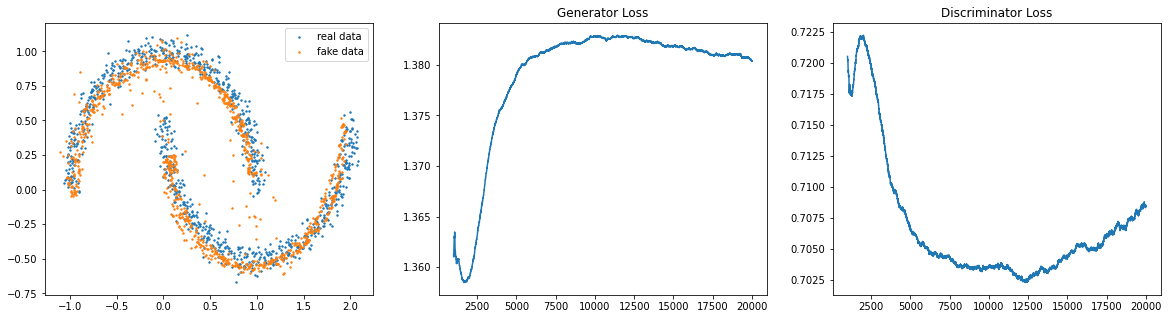



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=256, bias=True)
  (fc_hid): ModuleList()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
) Depth  2 Width 256
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.974e-01, generator: 1.385e+00




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (fc2): Linear(in_features=4, out_features=2, bias=True)
) Depth  3 Width 4
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 1.201e+00, generator: 1.036e+00


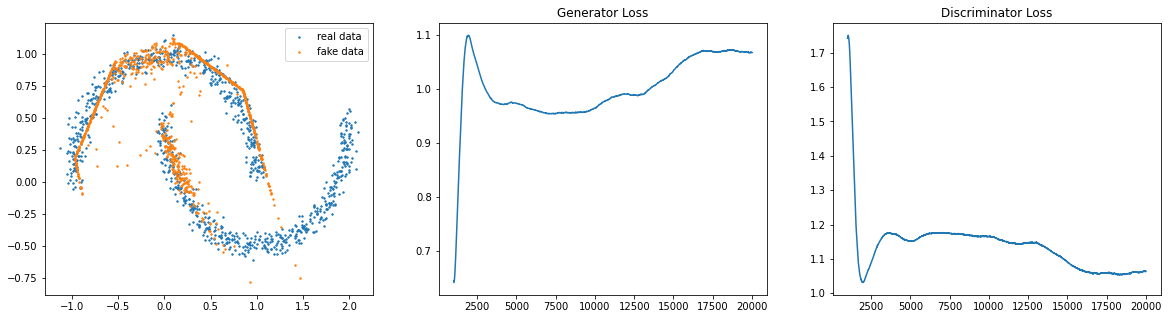



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc2): Linear(in_features=16, out_features=2, bias=True)
) Depth  3 Width 16
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.963e-01, generator: 1.386e+00




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=2, bias=True)
) Depth  3 Width 64
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.926e-01, generator: 1.386e+00




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.958e-01, generator: 1.386e+00


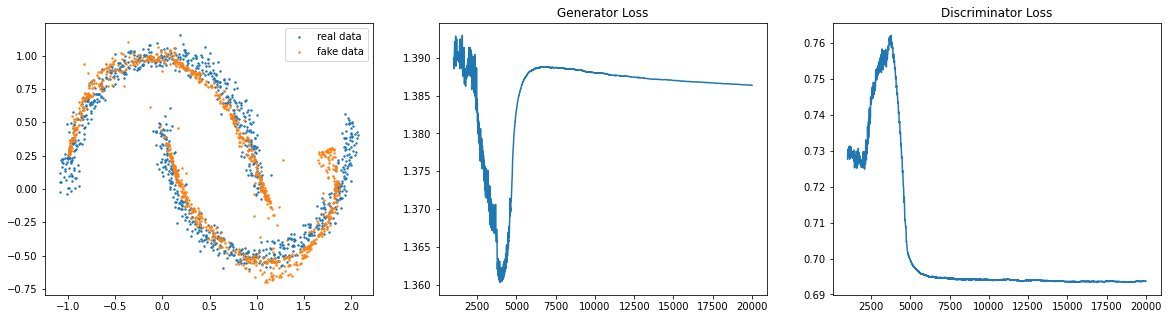



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=256, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc2): Linear(in_features=256, out_features=2, bias=True)
) Depth  3 Width 256
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.961e-01, generator: 1.384e+00


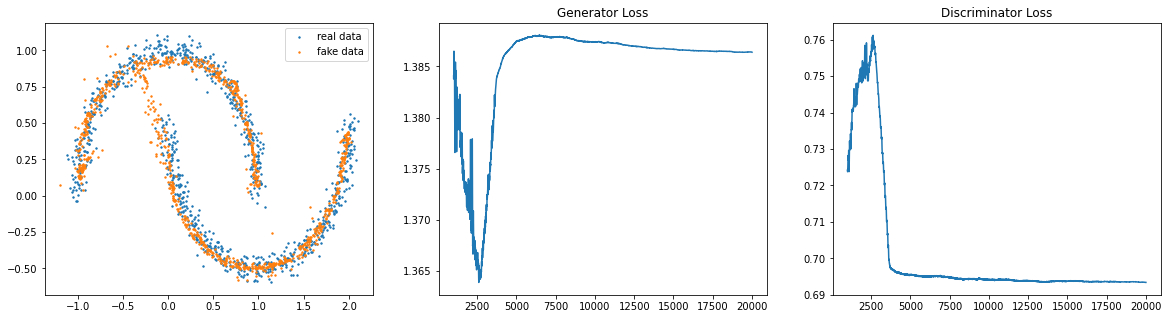



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=4, bias=True)
  )
  (fc2): Linear(in_features=4, out_features=2, bias=True)
) Depth  4 Width 4
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 1.225e+00, generator: 9.889e-01


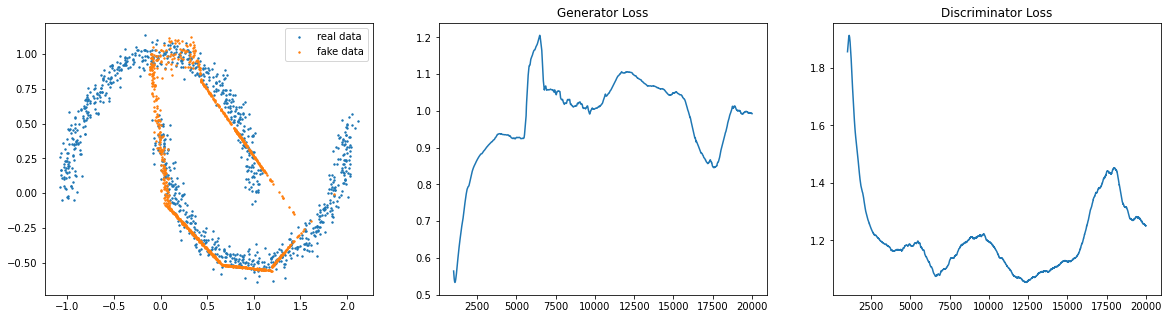



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc2): Linear(in_features=16, out_features=2, bias=True)
) Depth  4 Width 16
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.943e-01, generator: 1.387e+00


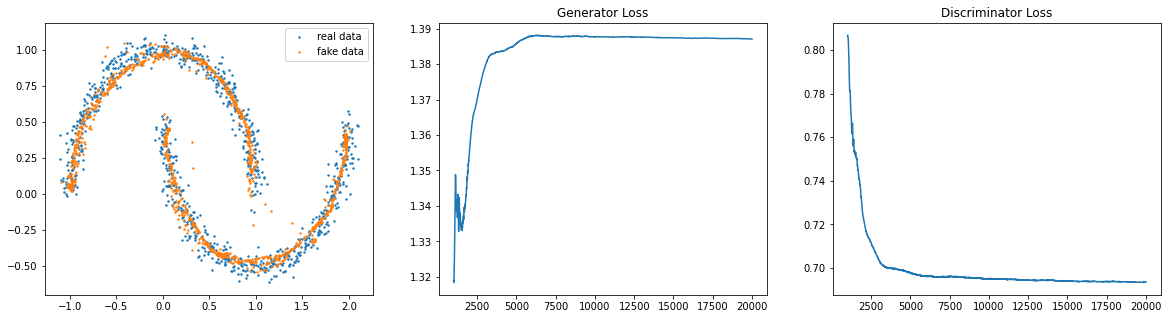



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=2, bias=True)
) Depth  4 Width 64
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.954e-01, generator: 1.387e+00


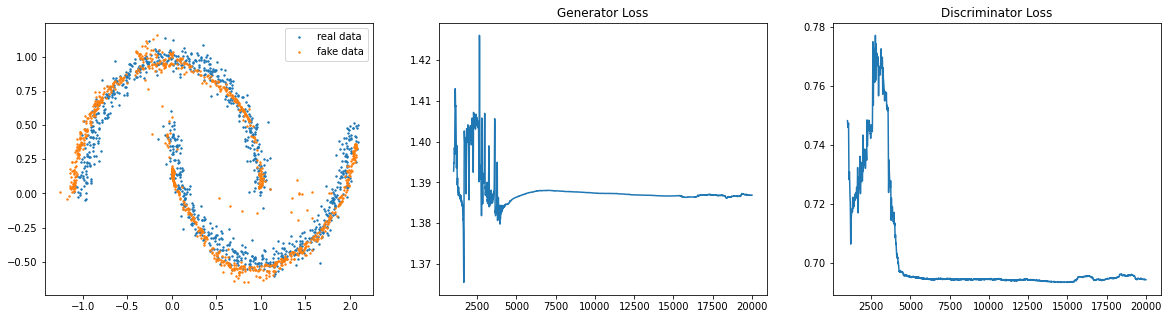



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  4 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.980e-01, generator: 1.387e+00


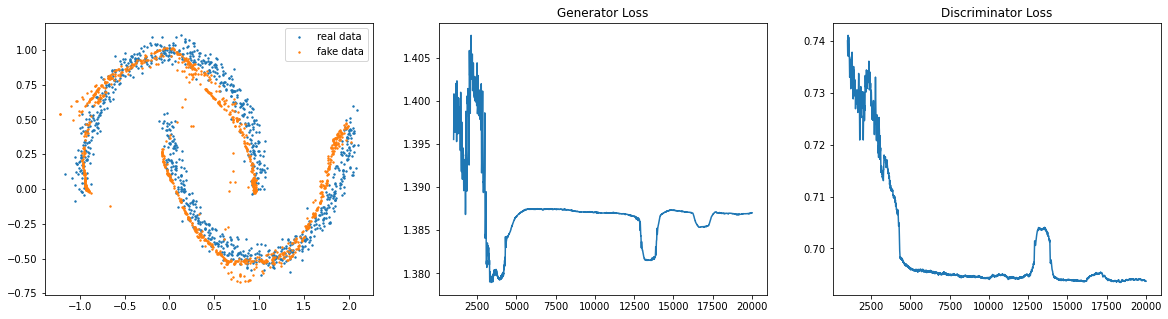



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=256, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc2): Linear(in_features=256, out_features=2, bias=True)
) Depth  4 Width 256
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 7.218e-01, generator: 1.387e+00




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=4, bias=True)
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (fc2): Linear(in_features=4, out_features=2, bias=True)
) Depth  5 Width 4
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 7.917e-01, generator: 1.212e+00


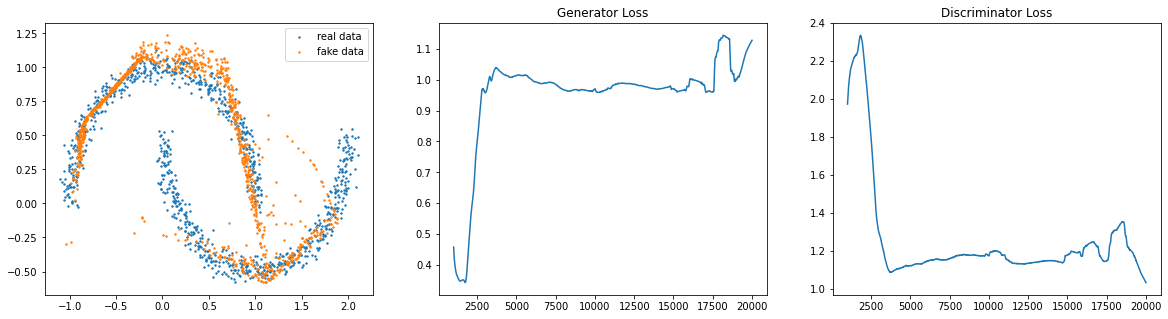



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc2): Linear(in_features=16, out_features=2, bias=True)
) Depth  5 Width 16
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.857e-01, generator: 1.384e+00




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=2, bias=True)
) Depth  5 Width 64
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 7.150e-01, generator: 1.382e+00


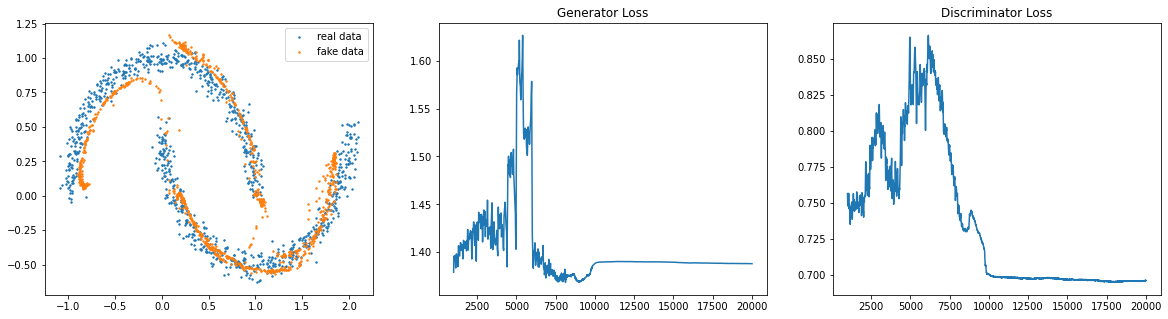



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  5 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 7.124e-01, generator: 1.384e+00


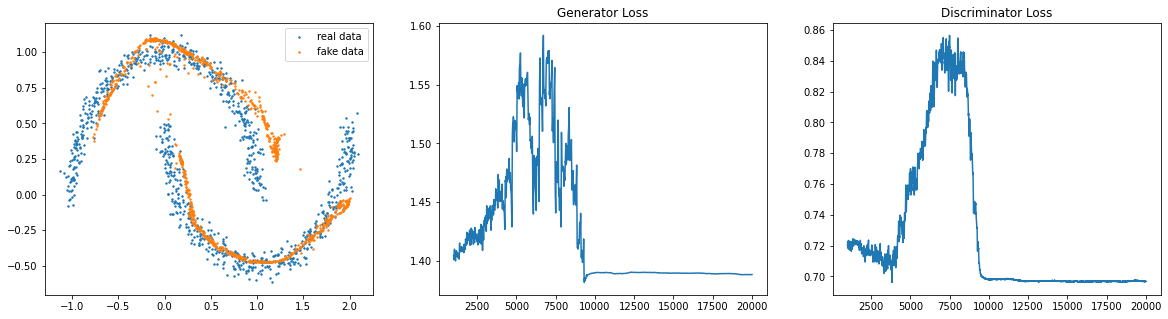



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=256, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc2): Linear(in_features=256, out_features=2, bias=True)
) Depth  5 Width 256
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 2.496e+00, generator: 1.507e-01


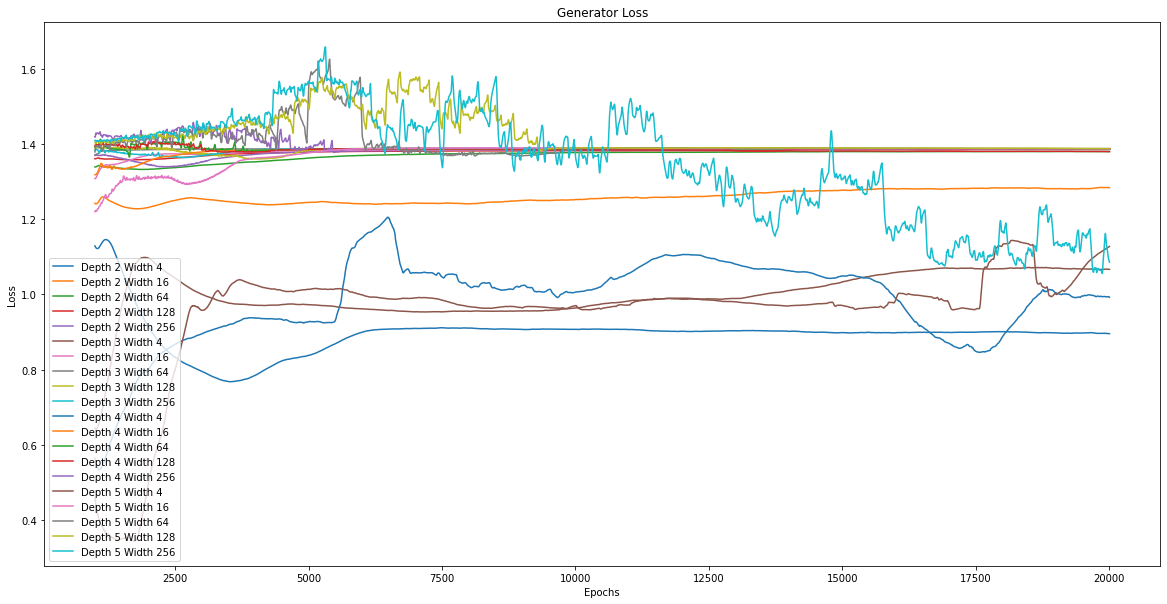

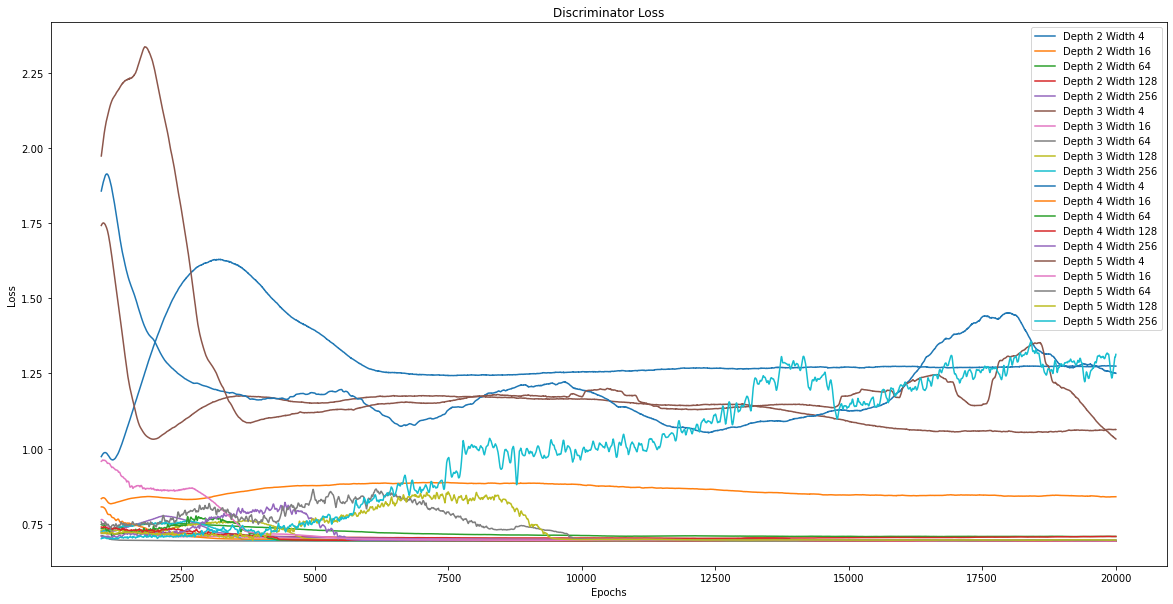

In [ ]:
# Generator
depth = [2, 3, 4, 5]
width = [4, 16, 64, 128]
TRAIN_RATIO = 1
gen_loss_list = []
dis_loss_list = []
labels_list = []

for d in depth:
  for w in width:
    generator = Generator(d, w).to(device)
    discriminator = Discriminator().to(device)
    gen_loss, dis_loss = train(TRAIN_RATIO, discriminator, generator)
    print_results(generator, discriminator, gen_loss, dis_loss)
    gen_loss_list.append(gen_loss)
    dis_loss_list.append(dis_loss)
    labels_list.append("Depth "+str(d)+" Width "+str(w))

fig = plt.figure(figsize=(20,10))
for i, loss in enumerate(gen_loss_list):
    plt.plot(pd.Series(loss).rolling(window=1000).mean(), label=labels_list[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()
plt.show()

fig = plt.figure(figsize=(20,10))
for i, loss in enumerate(dis_loss_list):
    plt.plot(pd.Series(loss).rolling(window=1000).mean(), label=labels_list[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()
plt.show()



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
) Depth  2 Width 16
Loss at final Step : discriminator: 6.895e-01, generator: 1.386e+00




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  2 Width 64
Loss at final Step : discriminator: 9.885e-01, generator: 8.713e-01




 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
) Depth  2 Width 128
Loss at final Step : discriminator: 1.654e-01, generator: 3.166e+00


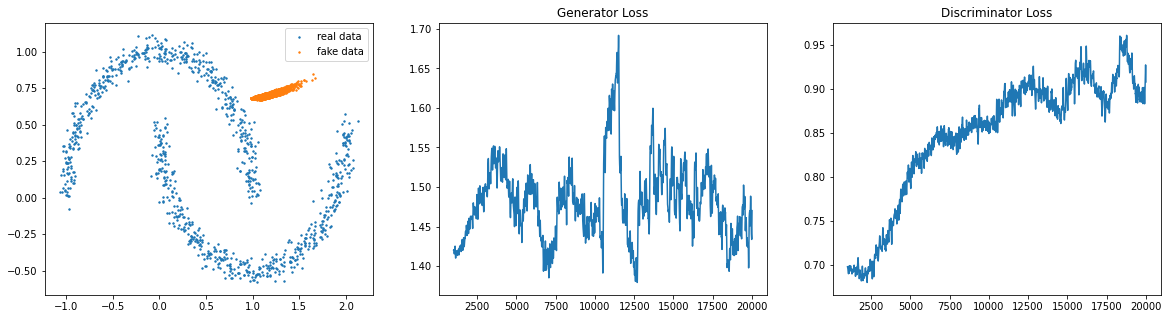



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc2): Linear(in_features=16, out_features=1, bias=True)
) Depth  3 Width 16
Loss at final Step : discriminator: 6.788e-01, generator: 1.386e+00


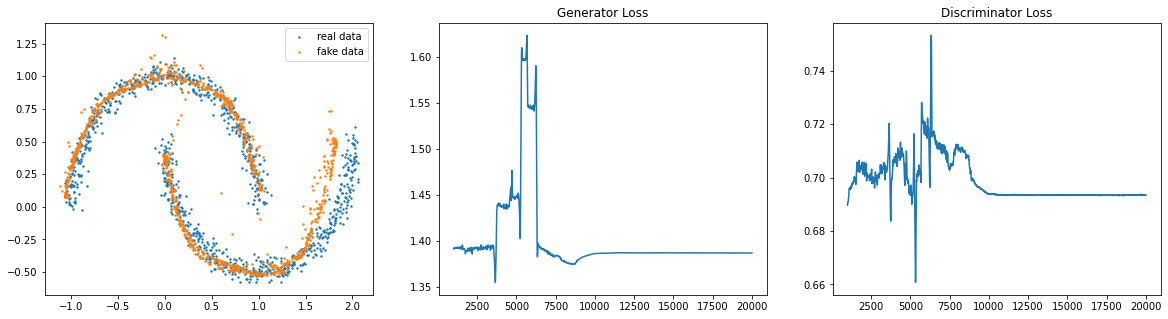



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.957e-01, generator: 1.386e+00


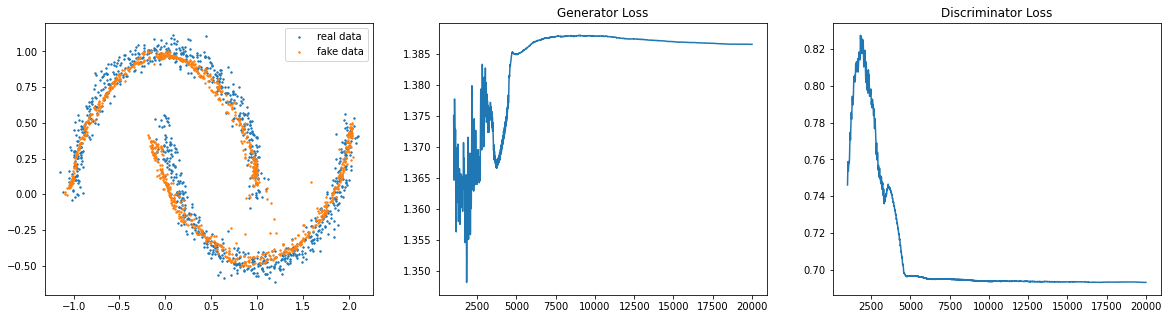



 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=1, bias=True)
) Depth  3 Width 128
Loss at final Step : discriminator: 6.903e-01, generator: 1.387e+00


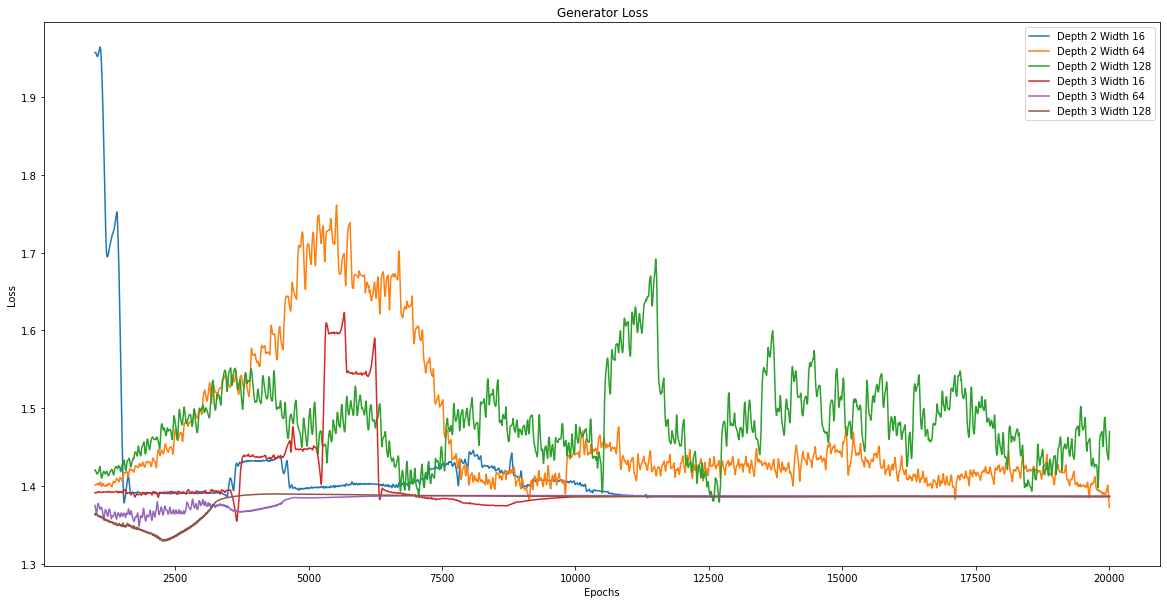

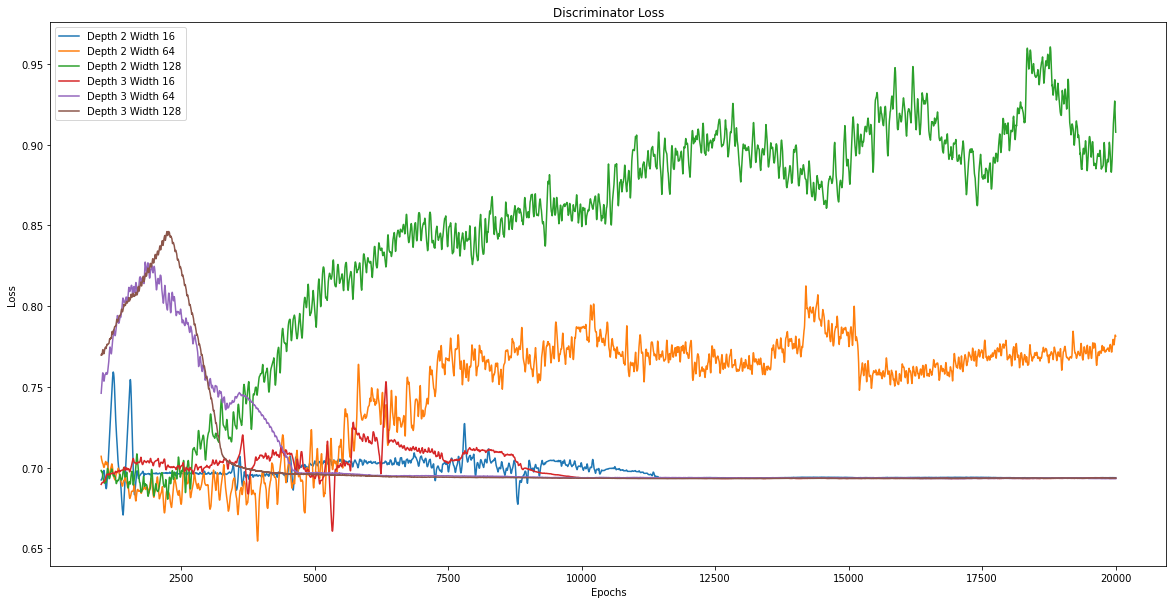

In [ ]:
# Discriminator
depth = [2, 3]
width = [16, 64, 128]
TRAIN_RATIO = 1

gen_loss_list = []
dis_loss_list = []
labels_list = []

for d in depth:
  for w in width:
    generator = Generator().to(device)
    discriminator = Discriminator(d, w).to(device)
    gen_loss, dis_loss = train(TRAIN_RATIO, discriminator, generator)
    print_results(generator, discriminator, gen_loss, dis_loss)
    gen_loss_list.append(gen_loss)
    dis_loss_list.append(dis_loss)
    labels_list.append("Depth "+str(d)+" Width "+str(w))

fig = plt.figure(figsize=(20,10))
for i, loss in enumerate(gen_loss_list):
    plt.plot(pd.Series(loss).rolling(window=1000).mean(), label=labels_list[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()
plt.show()

fig = plt.figure(figsize=(20,10))
for i, loss in enumerate(dis_loss_list):
    plt.plot(pd.Series(loss).rolling(window=1000).mean(), label=labels_list[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()
plt.show()

Train ratio 1


 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.888e-01, generator: 1.387e+00


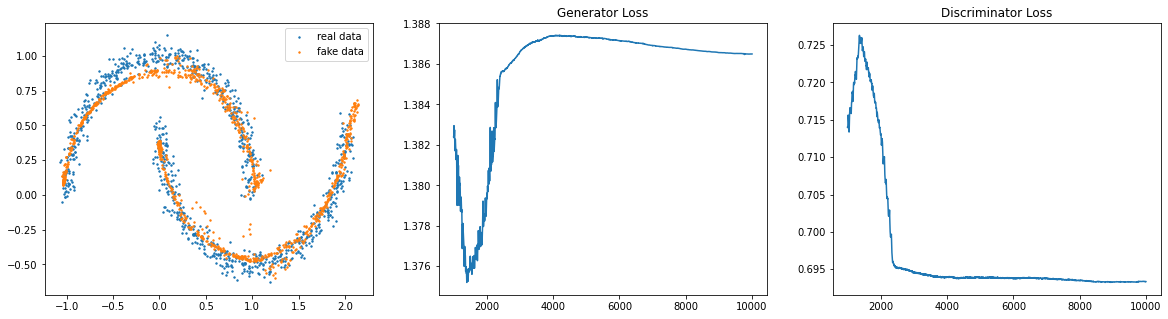

Train ratio 5


 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.971e-01, generator: 1.378e+00


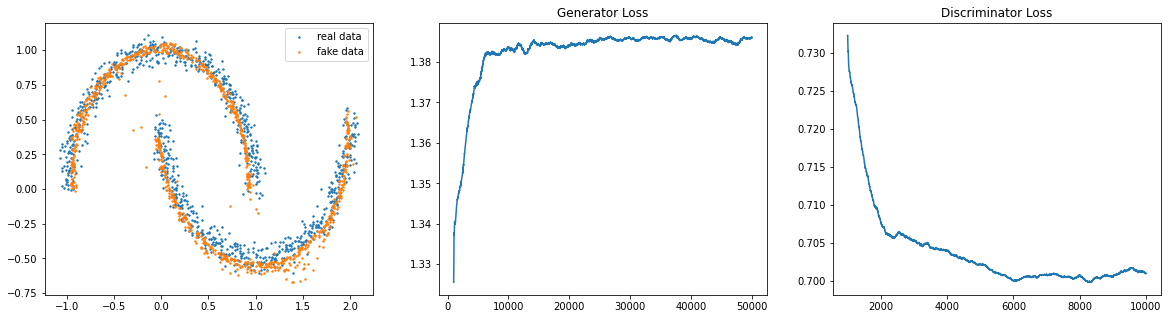

Train ratio 10


 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 6.969e-01, generator: 1.386e+00


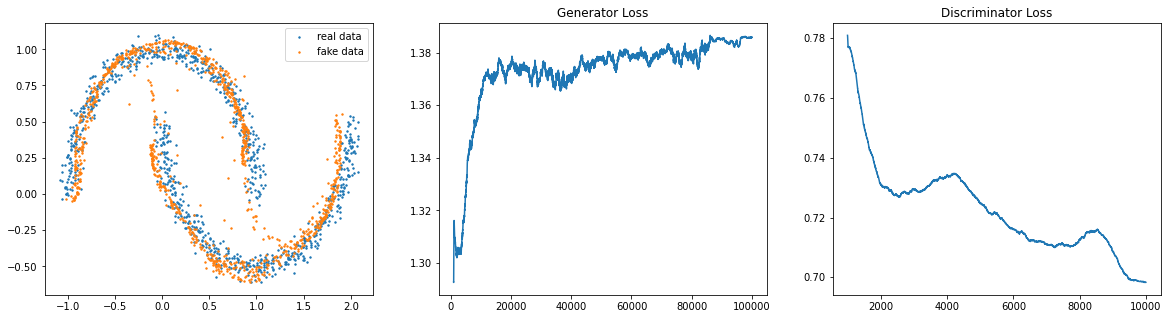

Train ratio 20


 __________________
Generator : Generator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
) Depth  3 Width 128
Discriminator Discriminator(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
) Depth  3 Width 64
Loss at final Step : discriminator: 7.206e-01, generator: 1.368e+00


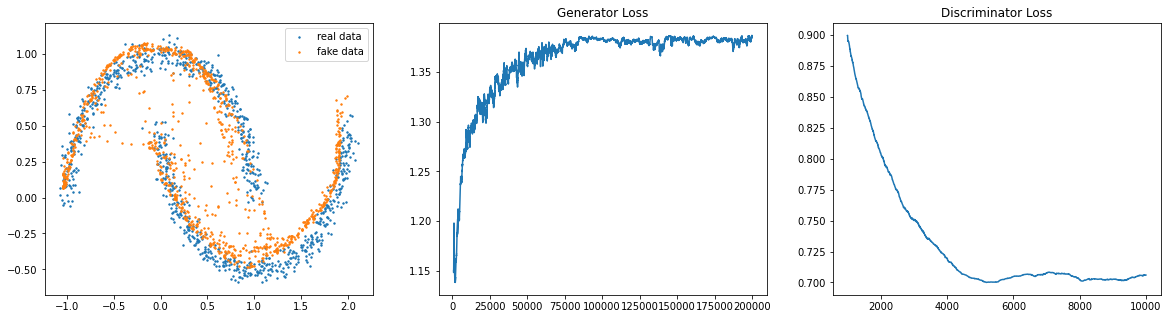

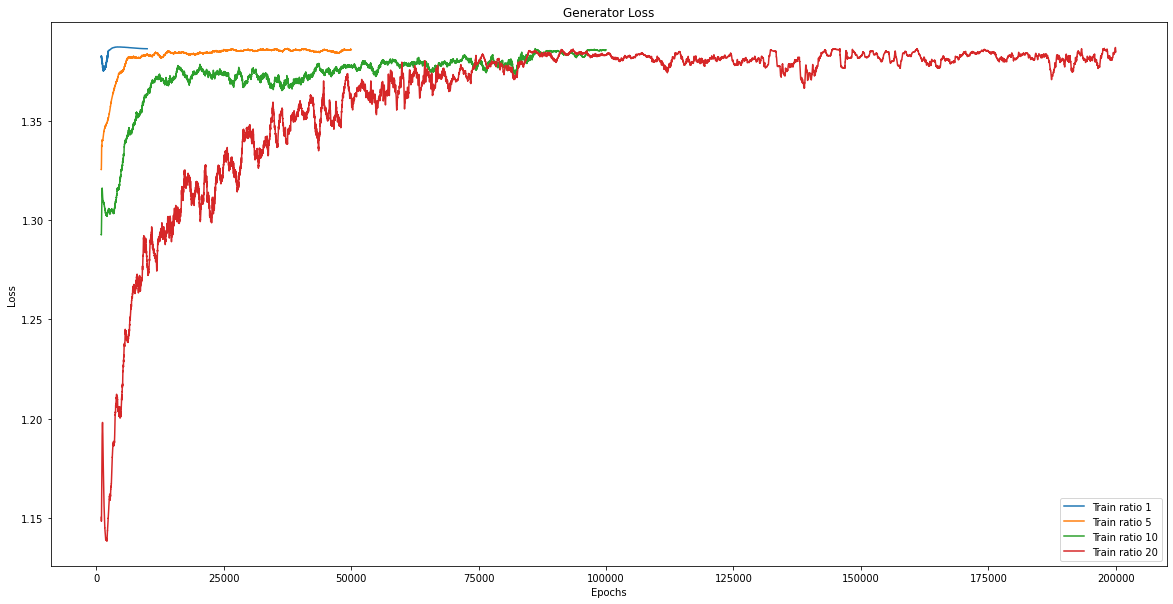

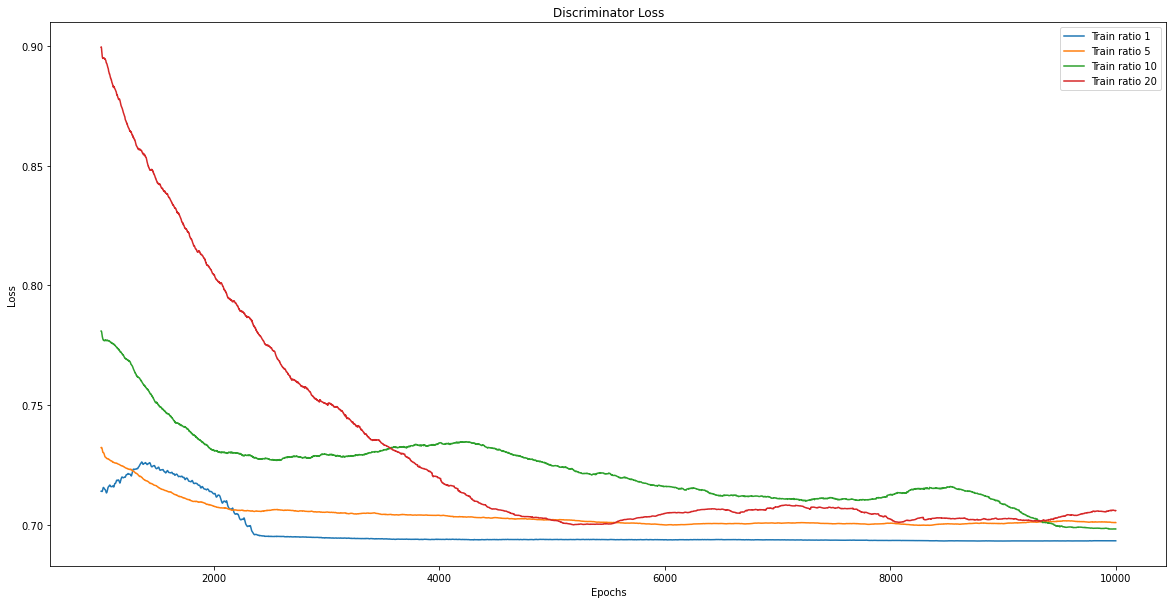

In [ ]:
#Train Ratio
TRAIN_RATIOs = [1,5,10,20]
N_ITER = 10000
TRAIN_RATIOs_loss = []

gen_loss_list = []
dis_loss_list = []
labels_list = []

for t in TRAIN_RATIOs:
    print("Train ratio", t)
    generator = Generator()
    discriminator = Discriminator()
    gen_loss, dis_loss = train(t, discriminator, generator)
    print_results(generator, discriminator, gen_loss, dis_loss)
    gen_loss_list.append(gen_loss)
    dis_loss_list.append(dis_loss)
    labels_list.append("Train ratio "+str(t))

fig = plt.figure(figsize=(20,10))
for i, loss in enumerate(gen_loss_list):
    plt.plot(pd.Series(loss).rolling(window=1000).mean(), label=labels_list[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()
plt.show()

fig = plt.figure(figsize=(20,10))
for i, loss in enumerate(dis_loss_list):
    plt.plot(pd.Series(loss).rolling(window=1000).mean(), label=labels_list[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()
plt.show()

> - Depth and width of the discriminator : the width has to be larger than a given threshold (more than 16 neurons), otherwise the discriminator is not good enough for the generator. Above these thresholds, the higher the width or the deeper the discriminator, the more likely vanishing gradient are. A smaller model prevents the discriminator from collapsing and learns faster too.
>
> - Depth and width of the generator : if the depth and width of the generator are too small, the generator is too shallow and not complex enough to generate consistent data. If width is really small (between 2 and 8), we can even see the lines of perceptrons, a larger width gives a more circular shape. On the other hand if the generator is deep and wide (4 layers or more of 128 neurons or more), the odds of collapsing are higher. 
>
> - Impact of train ratio : A train ratio between 1 and 5 seems to give better results. Higher value leads to longer and nosier training.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> $$
\begin{align*} 
D_{KL}(p_D \| p_\theta) &= \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]\\
&=\mathbb{E}_{p_D}\left[ log(p_D(x) \right] - \mathbb{E}_{p_D}\left[ log(p_\theta(x)) \right]\\
\end{align*}
$$
>
> $\mathbb{E}_{p_D}\left[ log(p_D(x) \right]$ does not depends of $\theta$ therefore maximizing $\mathbb{E}_{p_D}\left[ log(p_\theta(x)) \right]$ and minimizing $D_{KL}(p_D \| p_\theta)$ are equivalent.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> $p(z)$ is never sampled during the training, therefore the KL-divergence $D_{KL}(q_\phi(z | x) \| p(z))$ can not be estimated empirically. We need assumptions on $p(z)$ to make the KL-divergence term computable.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> As a multivariate Normal distribution, $$\begin{align*}
p(z) &= \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} exp \left[\frac{-(z-\mu)^T\Sigma^{-1}(z-\mu)}{2}\right]\\
&= \frac{1}{(2\pi)^{d/2}} exp \left[\frac{-z^Tz}{2}\right]
\end{align*}$$ with $d$ the dimension of $z$. 
>
> $$
\begin{align*} 
D_{KL}(q_\phi(z | x) \| p) &= \mathbb{E}_{q_\phi(z | x)}\left[ log(q_\phi(z | x) - log(p(x)) \right]\\
&= \mathbb{E}_{q_\phi(z | x)}\left[ -\frac{d}{2}log(2\pi) - \frac{1}{2} log(| \Sigma_\phi(x)|) -\frac{1}{2} (z-\mu_\phi(x))^T\Sigma_\phi^{-1}(x)(z-\mu_\phi(x)) + \frac{d}{2}log(2\pi) +\frac{1}{2} z^Tz \right]\\
&= \frac{1}{2} (\mathbb{E}_{q_\phi(z | x)}\left[ z^T z -(z-\mu_\phi(x))^T\Sigma_\phi^{-1}(x)(z-\mu_\phi(x)) \right] - \sum_i log(\sigma_\phi(x)^2_i))\\
\end{align*}
$$
> 
> With $\Sigma_\phi(x) = Diag(\sigma_\phi^2(x))$ the covariance of $q_\phi(.|x)$.
> Therefore $\sigma^2_\phi(x) = \mathbb{E}_{q_\phi(z | x)}\left[(z-\mu_\phi(x))^2\right]$. \\
>
>Then :
>$$ \mathbb{E}_{q_\phi(z | x)}\left[(z-\mu_\phi(x))^T\Sigma_\phi^{-1}(x)(z-\mu_\phi(x)) \right]=\sum_i \frac{1}{\sigma^2_\phi(x)_i}\mathbb{E}_{q_\phi(z | x)}\left[(z-\mu_\phi(x)_i)^2\right] = d $$
>
> And :
> $$
\begin{align*}
\mathbb{E}_{q_\phi(z | x)} \left[ z^T z \right] &= \mathbb{E}_{q_\phi(z | x)} \left[ (z -\mu_\phi(x)+\mu_\phi(x) )^T (z -\mu_\phi(x)+\mu_\phi(x)) \right] \\
&= \mathbb{E}_{q_\phi(z | x)} \left[ (z -\mu_\phi(x))^T (z -\mu_\phi(x)) \right] + \mu_\phi(x)^T \mu_\phi(x)  + 2 \mu_\phi(x) \mathbb{E}_{q_\phi(z | x)} \left[ z -\mu_\phi(x) \right]\\
&= \mu_\phi(x)^T\mu_\phi(x)+tr(\Sigma_\phi(x)) 
\end{align*}
$$
>
>Therefore we get : $D_{KL}(q_\phi(z | x) \| p)= \frac{1}{2} (\mu_\phi(x)^T\mu_\phi(x)+tr(\Sigma_\phi(x)) +d - \sum_i log(\sigma_\phi(x)^2_i))$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> With $ \Sigma_\theta(z) = Diag(\sigma_\theta^2(z))$ :
$$
\begin{align*}
p_\theta(x|z) &= \frac{1}{(2\pi)^{d/2} |\Sigma_\theta(z)|^{1/2}} exp \left[\frac{-(x-\mu_\theta(z)))^T\Sigma_\theta(z)^{-1}(x-\mu_\theta(z))}{2}\right]\\
-log(p_\theta(x|z)) &= \frac{1}{2} (d \log(2\pi) + \log|\Sigma_\theta(z)| + (x-\mu_\theta(z))^T\Sigma_\theta(z)^{-1}(x-\mu_\theta(z)))
\end{align*}
$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self, d=2, w=32):
        super().__init__()
        self.depth = d
        self.width = w
        self.fc1 = nn.Linear(2, w)
        self.fc_hid = nn.ModuleList()
        for _ in range(d-2):
            self.fc_hid.append(nn.Linear(w, w))
        self.fc_mu = nn.Linear(w, LATENT_N)
        self.fc_logvar = nn.Linear(w, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        for i in range(self.depth-2):
            h = F.relu(self.fc_hid[i](h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, d=2, w=32, var=None):
        super().__init__()
        self.depth = d
        self.width = w
        self.var = var
        self.fc1 = nn.Linear(LATENT_N, w)
        self.fc_hid = nn.ModuleList()
        for _ in range(d-2):
            self.fc_hid.append(nn.Linear(w, w))
        self.fc_mu = nn.Linear(w, 2)
        if var is None:
            self.fc_logvar = nn.Linear(w, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def forward(self, z, var=None):
        h = F.relu(self.fc1(z))
        for i in range(self.depth-2):
            h = F.relu(self.fc_hid[i](h))
        mu = self.fc_mu(h)
        if self.var is None:
          logvar = self.fc_logvar(h)
        else:
          logvar = np.log(self.var)*torch.ones(mu.shape)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.forward(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

In [ ]:
def print_results_VAE(encoder, decoder, loss):
  print("\n\n __________________")
  print("Encoder :", encoder, "Depth ", encoder.depth, "Width", encoder.width)
  print("Decoder", decoder, "Depth ", decoder.depth, "Width", decoder.width)
  print('Loss at final Step : encoder: {:.3e}, decoder: {:.3e}'.format( float(enc_loss[-1]), float(dec_loss[-1])))

  real_batch = generate_batch(1024)
  enc_mu, enc_logvar = encoder(real_batch)
  z = enc_mu + torch.exp(enc_logvar/2) * torch.normal(torch.zeros((1024, LATENT_N)), 1)
  dec_mu, dec_logvar = decoder(z)
  rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
  fake_batch = decoder.generate(1024).detach()

  fig = plt.figure(figsize=(20,5))
  ax = fig.add_subplot(1,2,1)
  ax.scatter(real_batch[:,0].cpu(), real_batch[:,1].cpu(), s=2.0, label='real data')
  ax.scatter(rec_batch[:,0].cpu(), rec_batch[:,1].cpu(), s=2.0, label='rec data')
  ax.scatter(fake_batch[:,0].cpu(), fake_batch[:,1].cpu(), s=2.0, label='fake data')
  ax.legend()
  ax = fig.add_subplot(1, 2, 2)
  ax.plot(pd.Series(loss).rolling(window=500).mean())
  ax.set_title('Encoder Loss + Decoder Loss')
  plt.show()

step 0: KL: 6.870e+02, rec: 1.011e+02


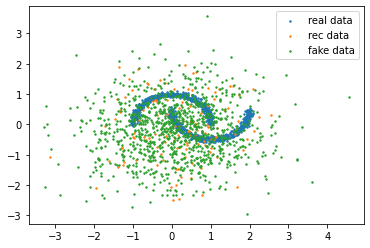

step 1000: KL: 6.850e+02, rec: -3.985e+01


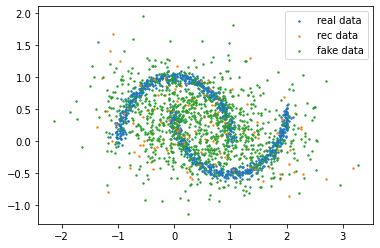

step 2000: KL: 7.628e+02, rec: -1.411e+02


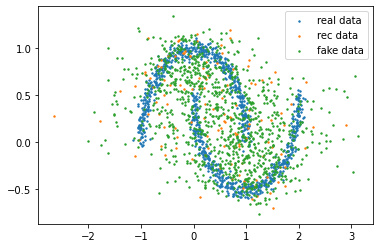

step 3000: KL: 8.228e+02, rec: -2.038e+02


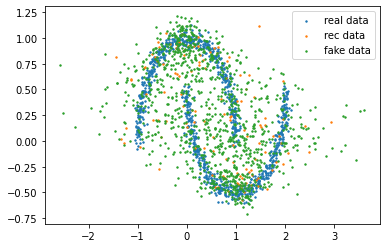

step 4000: KL: 8.341e+02, rec: -2.416e+02


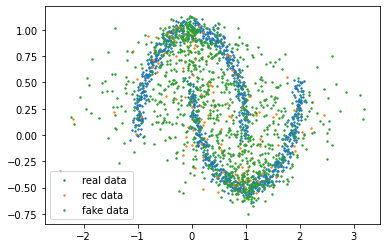

step 5000: KL: 8.318e+02, rec: -2.402e+02


step 6000: KL: 8.385e+02, rec: -2.436e+02


step 7000: KL: 8.426e+02, rec: -2.473e+02


step 8000: KL: 8.440e+02, rec: -2.451e+02


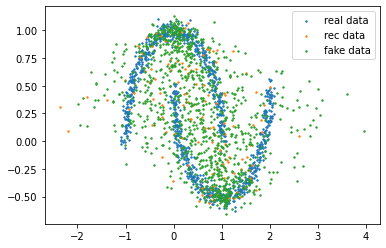

step 9000: KL: 8.483e+02, rec: -2.607e+02


step 10000: KL: 8.491e+02, rec: -2.516e+02


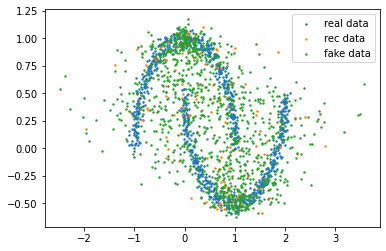

step 11000: KL: 8.505e+02, rec: -2.566e+02


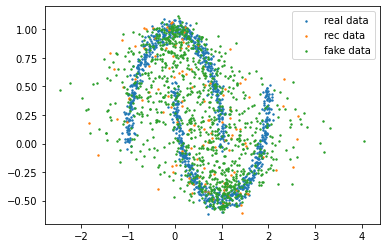

step 12000: KL: 8.508e+02, rec: -2.572e+02


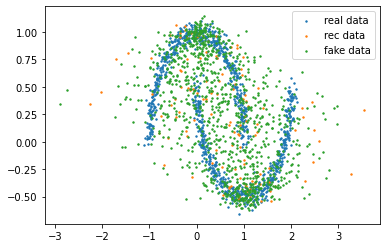

step 13000: KL: 8.535e+02, rec: -2.368e+02


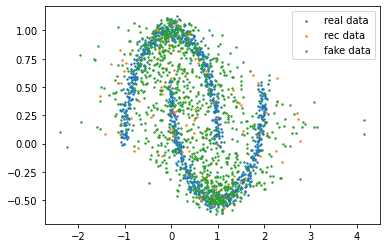

step 14000: KL: 8.549e+02, rec: -2.549e+02


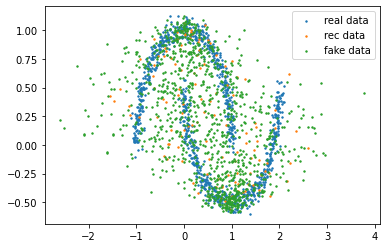

step 15000: KL: 8.553e+02, rec: -2.491e+02


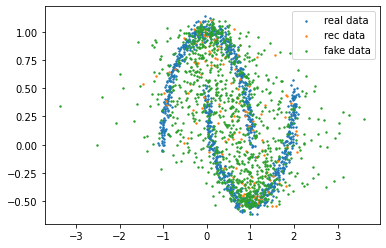

step 16000: KL: 8.524e+02, rec: -2.460e+02


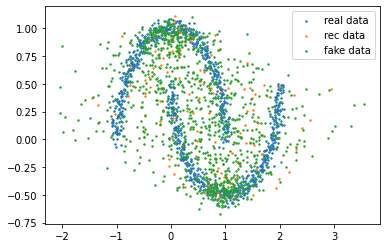

step 17000: KL: 8.575e+02, rec: -2.563e+02


step 18000: KL: 8.576e+02, rec: -2.597e+02


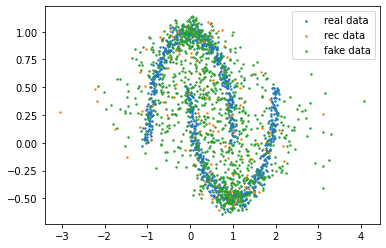

step 19000: KL: 8.622e+02, rec: -2.605e+02


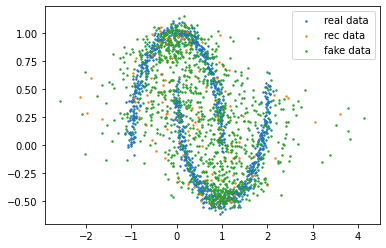

step 20000: KL: 8.555e+02, rec: -2.551e+02


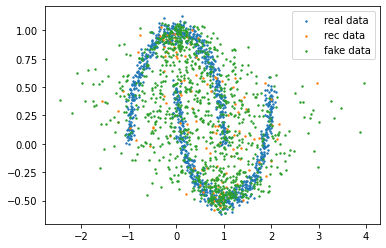

step 21000: KL: 8.619e+02, rec: -2.583e+02


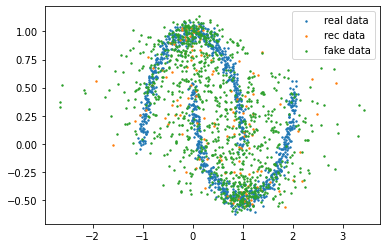

step 22000: KL: 8.574e+02, rec: -2.635e+02


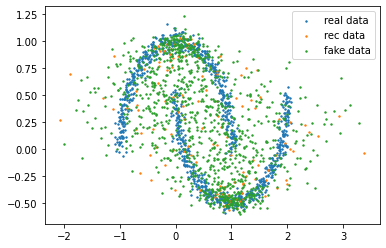

step 23000: KL: 8.599e+02, rec: -2.739e+02


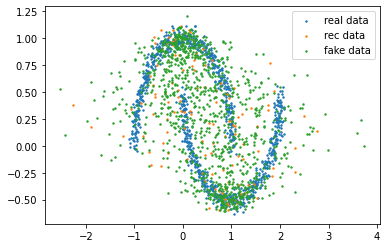

step 24000: KL: 8.620e+02, rec: -2.752e+02


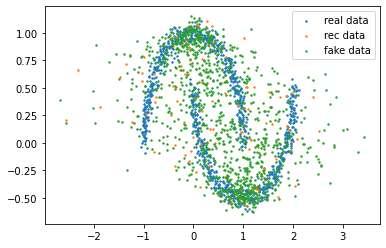

step 25000: KL: 8.608e+02, rec: -2.678e+02


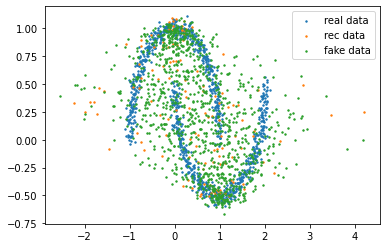

step 26000: KL: 8.625e+02, rec: -2.703e+02


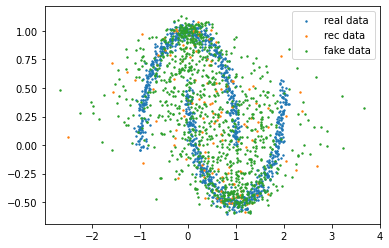

step 27000: KL: 8.619e+02, rec: -2.613e+02


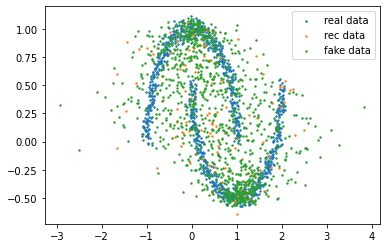

step 28000: KL: 8.643e+02, rec: -2.763e+02


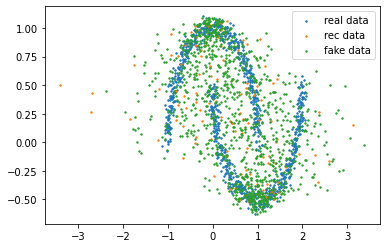

step 29000: KL: 8.588e+02, rec: -2.570e+02


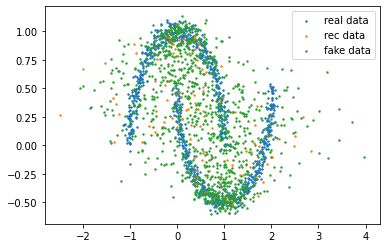

step 30000: KL: 8.636e+02, rec: -2.747e+02


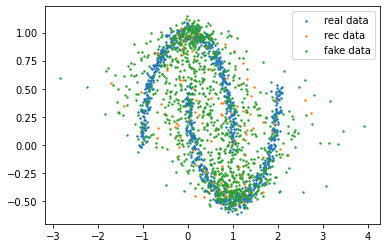

step 31000: KL: 8.669e+02, rec: -2.715e+02


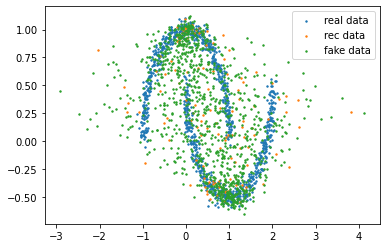

step 32000: KL: 8.633e+02, rec: -2.739e+02


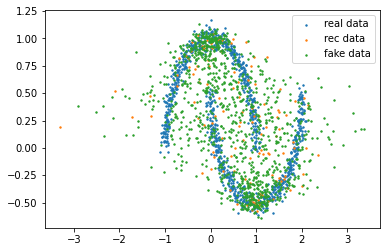

step 33000: KL: 8.630e+02, rec: -2.693e+02


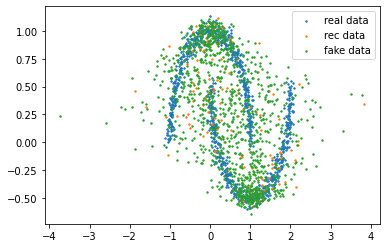

step 34000: KL: 8.623e+02, rec: -2.793e+02


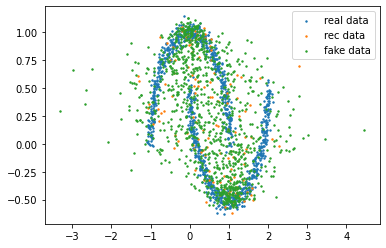

step 35000: KL: 8.671e+02, rec: -2.597e+02


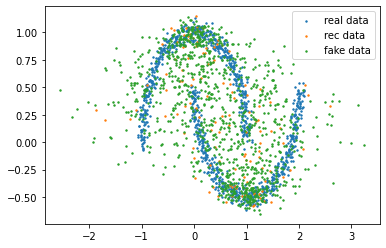

step 36000: KL: 8.637e+02, rec: -2.792e+02


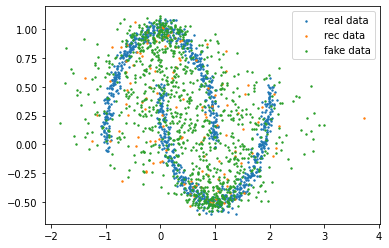

step 37000: KL: 8.657e+02, rec: -2.821e+02


step 38000: KL: 8.655e+02, rec: -2.619e+02


step 39000: KL: 8.654e+02, rec: -2.675e+02


step 40000: KL: 8.646e+02, rec: -2.526e+02


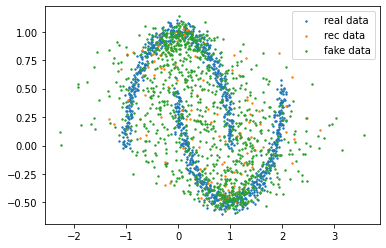



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  2 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


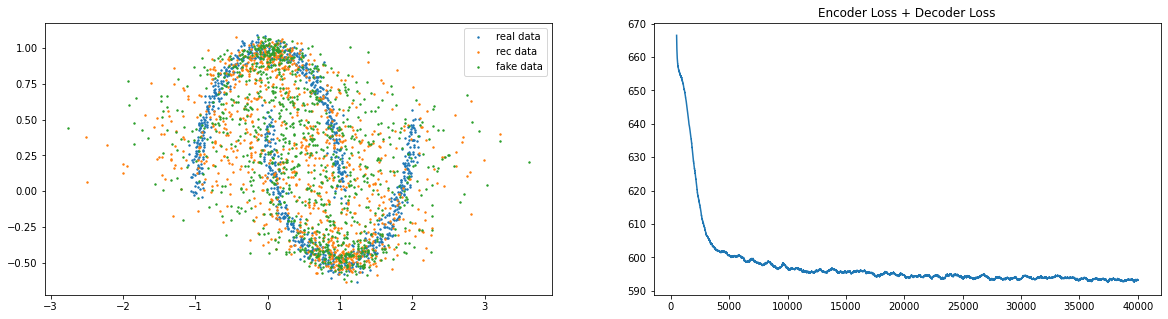

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

def train_VAE(encoder, decoder, plot=False, var=None):
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

    hist_loss = []
    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()
        
        x = generate_batch(BATCHLEN)
        
        enc_mu, enc_logvar = encoder(x)
        #
        # COMPUTE THE KL PART OF THE LOSS HERE
        #
        loss_kl = 0.5 * torch.mean(torch.sum(enc_mu.pow(2) + torch.exp(enc_logvar) - enc_logvar))
        #
        # SAMPLE z FROM q(z|x) HERE
        #
        z = enc_mu + torch.exp(enc_logvar/2) * torch.normal(torch.zeros((BATCHLEN, LATENT_N)), 1)
        
        dec_mu, dec_logvar = decoder(z) # Var for hardcoring
        #
        # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
        #
        loss_rec = 0.5 * torch.mean(torch.sum(dec_logvar + (x - dec_mu).pow(2) / dec_logvar.exp()) + np.log(2 * np.pi))
        
        (loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()

        hist_loss.append(loss_kl.cpu().detach().numpy()+loss_rec.cpu().detach().numpy())
        if plot:
            if i%1000 == 0:
                print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
                # plot the result
                real_batch = generate_batch(1024)
                rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
                fake_batch = decoder.generate(1024).detach()
                plt.scatter(real_batch[:,0].cpu(), real_batch[:,1].cpu(), s=2.0, label='real data')
                plt.scatter(rec_batch[:,0].cpu(), rec_batch[:,1].cpu(), s=2.0, label='rec data')
                plt.scatter(fake_batch[:,0].cpu(), fake_batch[:,1].cpu(), s=2.0, label='fake data')
                plt.legend()
                plt.show()
    return hist_loss

encoder = Encoder().to(device)
decoder = Decoder().to(device)
loss = train_VAE(encoder, decoder, plot=True)
print_results_VAE(encoder, decoder, loss)

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  2 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


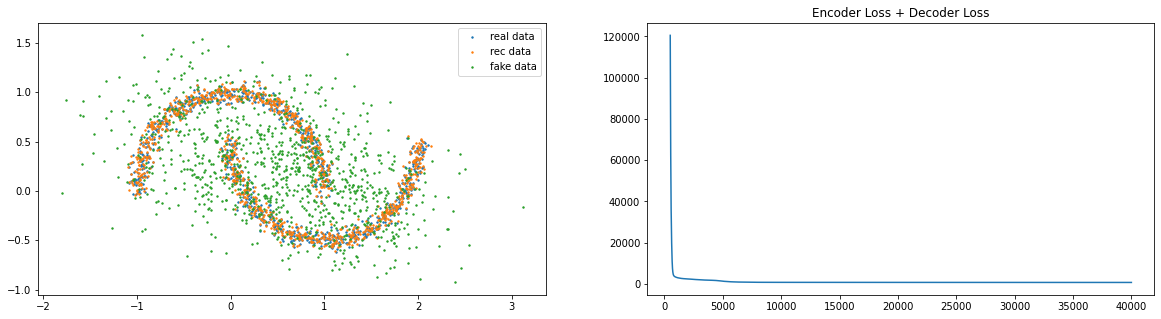

In [ ]:
sigma = 1e-4
encoder = Encoder().to(device)
decoder = Decoder(var=sigma).to(device)
loss = train_VAE(encoder, decoder, var = sigma)
print_results_VAE(encoder, decoder, loss)

> Hardcoring $\sigma_\theta(z)$ and minimizing the reconstruction loss is  equivalent to minimizing the Mean Squared Error between $x$ and $\mu_\theta(z)$. This task is simpler, the model seems to converges faster and  better.
>
> Nonetheless, not estimating $\sigma_\theta(z)$ reduces the expressiveness of the Variational Auto Encoder. In the general case, the noise of the dataset does not follow a normal distribution, and assuming so would produce bad results.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=16, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=10, bias=True)
) Depth  2 Width 16
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


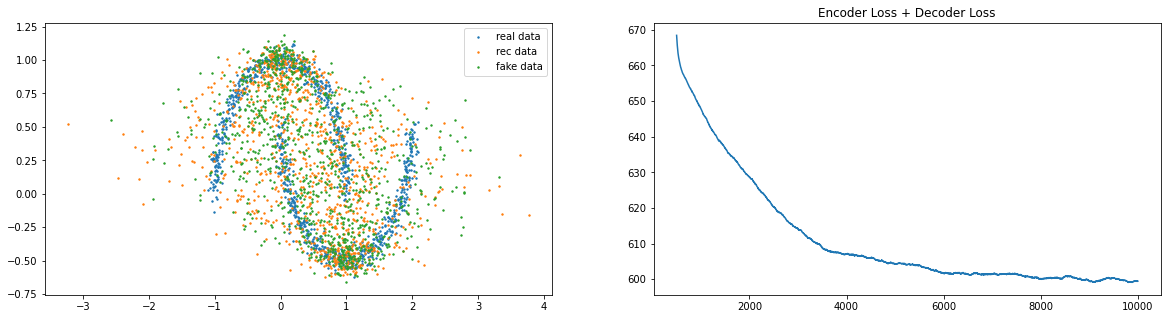



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  2 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


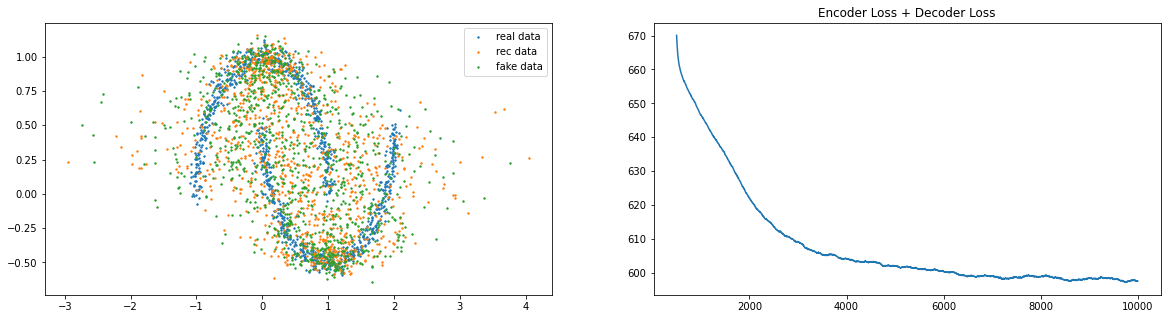



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=64, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=10, bias=True)
) Depth  2 Width 64
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


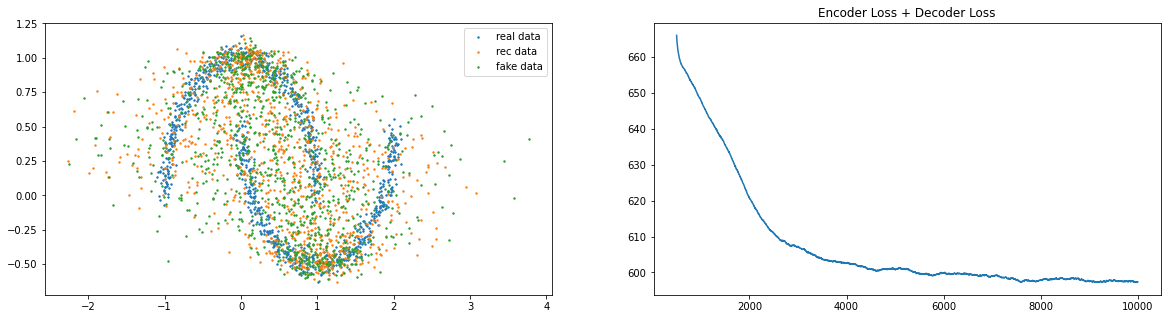



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc_mu): Linear(in_features=16, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=10, bias=True)
) Depth  3 Width 16
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03




 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  3 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03




 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc_mu): Linear(in_features=64, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=10, bias=True)
) Depth  3 Width 64
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


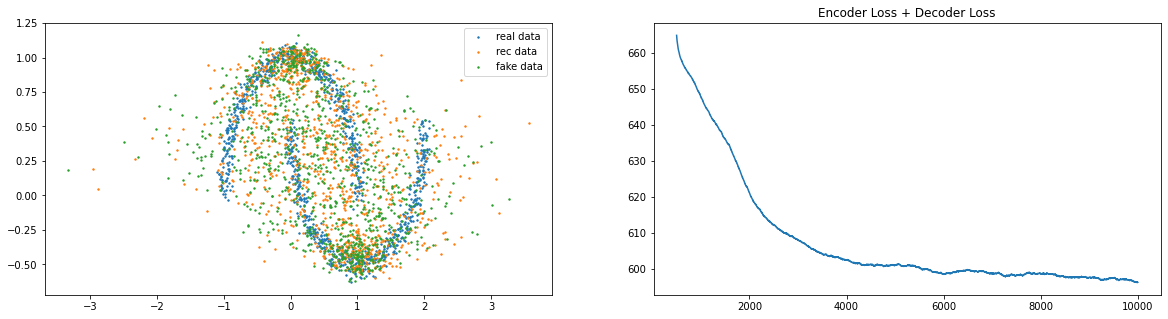



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc_mu): Linear(in_features=16, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=10, bias=True)
) Depth  4 Width 16
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


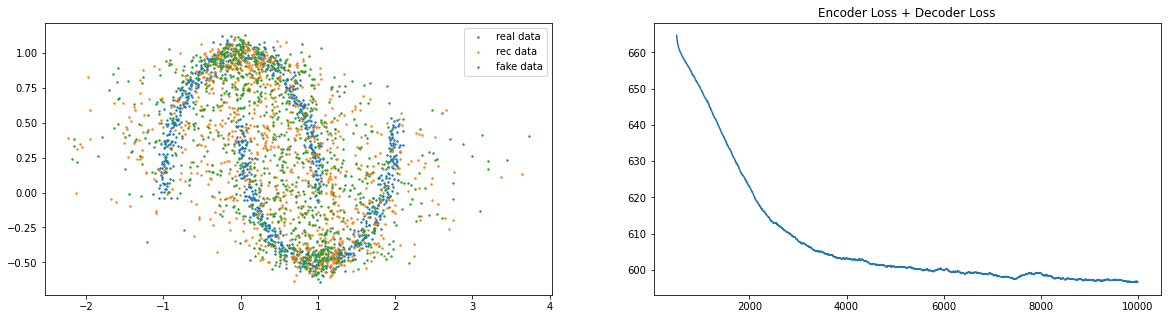



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  4 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03




 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc_mu): Linear(in_features=64, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=10, bias=True)
) Depth  4 Width 64
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


In [ ]:
# Encoder
depth = [2, 3, 4]
width = [ 16, 32, 64]
loss_list = []
labels_list = []

for d in depth:
  for w in width:
    encoder = Encoder(d, w).to(device)
    decoder = Decoder().to(device)
    loss = train_VAE(encoder, decoder)
    print_results_VAE(encoder, decoder, loss)
    loss_list.append(loss)
    labels_list.append("Depth "+str(d)+" Width "+str(w))

fig = plt.figure(figsize=(20,5))
for i, loss in enumerate(loss_list):
    plt.plot(pd.Series(loss).rolling(window=500).mean(), label=labels_list[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Encoder + Decoder Loss')
plt.legend()
plt.show()



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  2 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=16, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=16, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=2, bias=True)
) Depth  2 Width 16
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


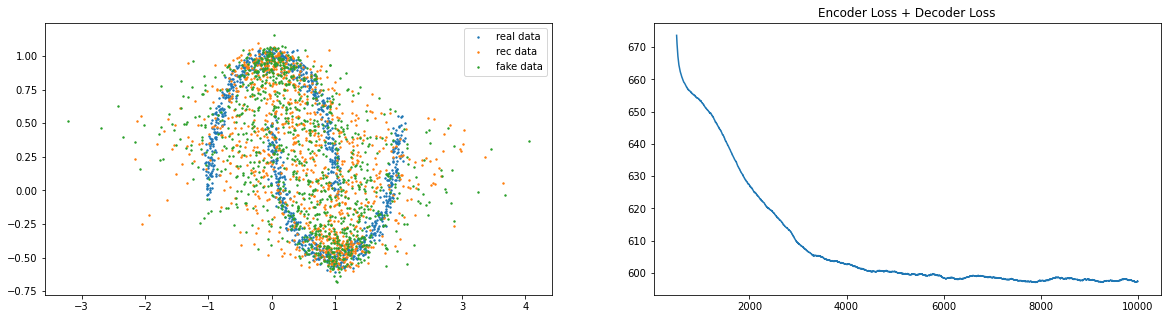



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  2 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  2 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


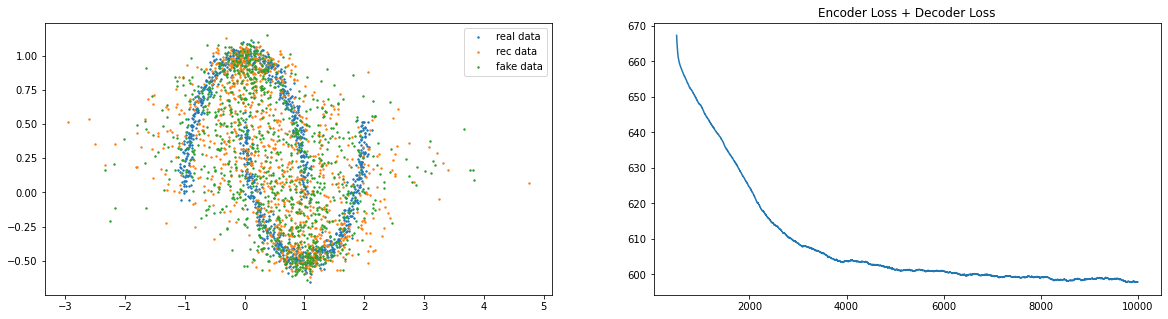



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  2 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=16, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc_mu): Linear(in_features=16, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=2, bias=True)
) Depth  3 Width 16
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


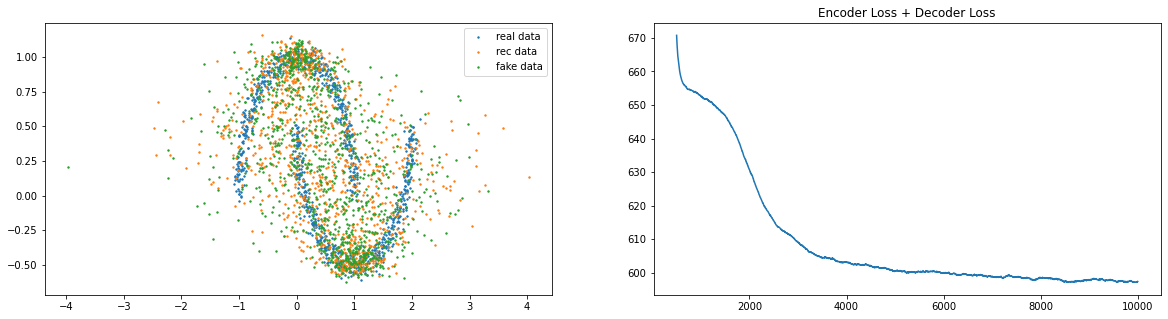



 __________________
Encoder : Encoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc_hid): ModuleList()
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
) Depth  2 Width 32
Decoder Decoder(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc_hid): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
) Depth  3 Width 32
Loss at final Step : encoder: 5.859e+01, decoder: -1.017e+03


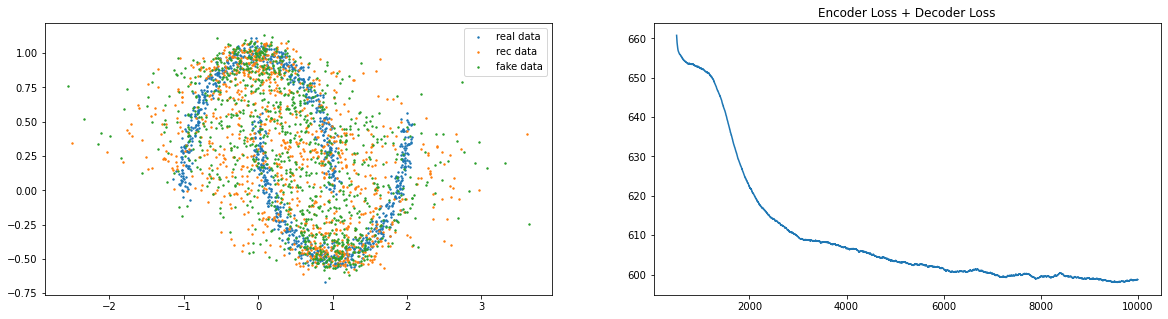

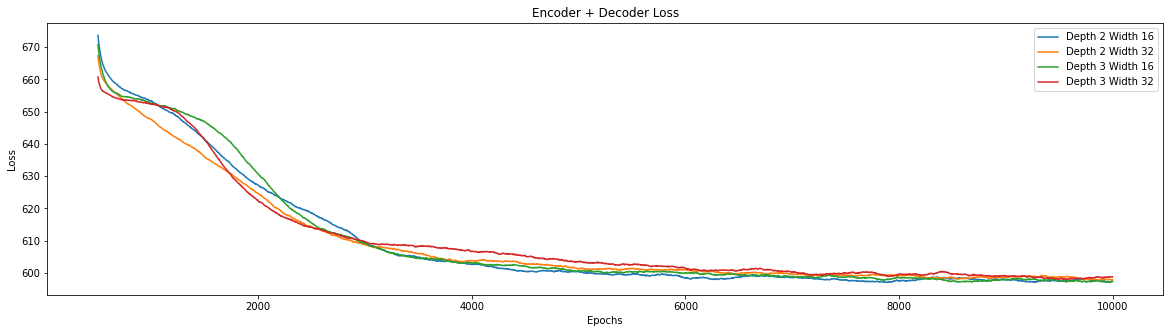

In [ ]:
# Decoder
depth = [2, 3]
width = [16, 32]
loss_list = []
labels_list = []

for d in depth:
  for w in width:
    encoder = Encoder().to(device)
    decoder = Decoder(d, w).to(device)
    loss = train_VAE(encoder, decoder)
    print_results_VAE(encoder, decoder, loss)
    loss_list.append(loss)
    labels_list.append("Depth "+str(d)+" Width "+str(w))

fig = plt.figure(figsize=(20, 5))
for i, loss in enumerate(loss_list):
    plt.plot(pd.Series(loss).rolling(window=500).mean(), label=labels_list[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Encoder + Decoder Loss')
plt.legend()
plt.show()


> - Autoencoder : the width seems to be the most important parameters, a width above a threshold (16 neurons approximately) gives a better loss covergence. Depth 3 seems to give good results. A model too heavy (deep or wide) doesn't provide better results and needs more time to train.
>
> - Decoder : a light model seems to give better results (2 layers of 16 neurons). A little wider model can accelerate convergence. But a model too heavy takes more time to train.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> We have $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. In other words:
$$\int_{z} g(f^{-1}(z)) \;p_\mathcal{N}(z)d(z) = \int_{x} g(x) \;p_{G}(x)d(x)$$

> With the change of variable $z=f(x)$, we have $dz = \det J_f(x) dx$. This is true for all $g$.

> So $p_G(x)=p_\mathcal{N}(z)\det J_f$ which leads to the above equality.

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

$$
\begin{align*}
KL(p_D||p_G) &= \mathbb{E}_{p_D}(\log(p_D(x)) - \log(p_G(x))) \\
             &= \mathbb{E}_{p_D}(\log(p_D(x)) - \log(p_\mathcal{N}(z)) - \log \det J_f ) \\
             &= \mathbb{E}_{p_D}(\log(p_D(x)) + \frac{d}{2}\log(2\pi) + \frac{f(x)^Tf(x)}{2} - \log \det J_f ) \\
             &= \mathbb{E}_{p_D}(\log(p_D(x)) + \frac{f(x)^Tf(x)}{2} - \log \det J_f ) + \frac{d}{2}\log(2\pi) 
\end{align*}
$$

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> Let's remark that we can directly express $x$ from $y$, thus meaning that the mapping is invertible.
> Indeed the inverse is really simple to express:
>* $x_{1:d} = y_{1:d}$
* $x_{d+1:D}=(y_{d+1:D} - t(y_{1:d}))\odot \exp(-s(y_{1:d})) $


**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> The Jacobian is clearly triangular since every varialbe can be expressed as a function of the previous variables.
> Moreover, the diagonal is filled with 1 up until the indice d, and then is filled by $\exp(s(x_{1:d}))$ from the indices d+1 to D.
>Thus, the determinant is the product of the diagonal values, thus it is:
$$\exp(\sum_j s(x_{1:d})_j)$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.sfun = nn.Sequential(*[nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.Tanh()])
        
        self.tfun = nn.Sequential(*[nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, output_size)])
        ###
        self.mask = mask #we use the mask variable to make the cut in input


        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        y = y_m + (1-self.mask)*( (y - self.tfun(y_m))*torch.exp(-self.sfun(y_m)))
        return y

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.017058
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.038313
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.049498
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.052136
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.053526
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.055139
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.055914
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.054858
====> Epoch: 1 Average train loss: -0.0482


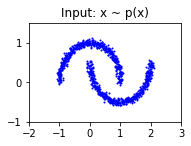

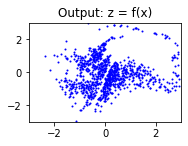

====> Test loss: -0.0574


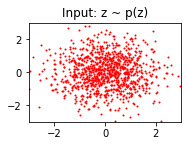

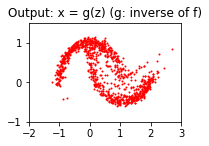

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.056652
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.056404
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.057079
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.057849
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.059051
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.058494
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.059121
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.058995
====> Epoch: 2 Average train loss: -0.0583


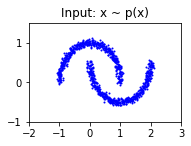

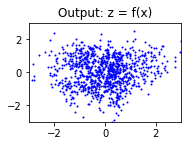

====> Test loss: -0.0606


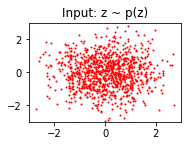

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.058826
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.059433
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.059240
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.059432
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058672
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.058990
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.059072
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.058904
====> Epoch: 3 Average train loss: -0.0592


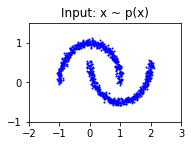

====> Test loss: -0.0611


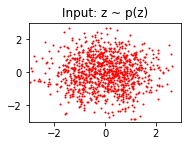

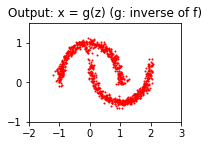

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.060281
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.058109
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.059270
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059012
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.058603
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.058841
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.059386
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.059812
====> Epoch: 4 Average train loss: -0.0594


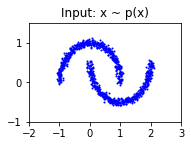

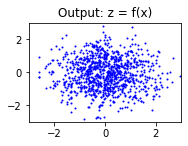

====> Test loss: -0.0614


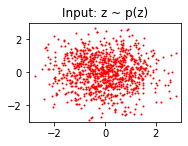

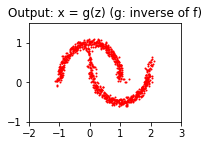

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059592
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059659
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.059656
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.059499
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.059862
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.059453
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059385
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059607
====> Epoch: 5 Average train loss: -0.0595


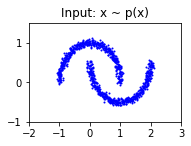

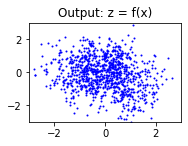

====> Test loss: -0.0610


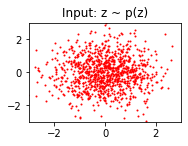

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.059568
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.058699
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.058901
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059746
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.058734
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.059606
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.059658
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.059416
====> Epoch: 6 Average train loss: -0.0596


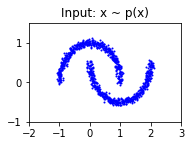

====> Test loss: -0.0613


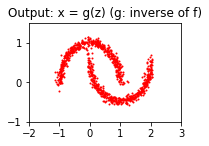

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059889
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.058807
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059077
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.060451
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.060339
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059790
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059338
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.059447
====> Epoch: 7 Average train loss: -0.0597


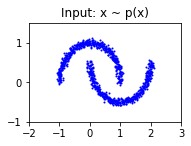

====> Test loss: -0.0616


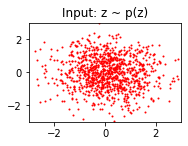

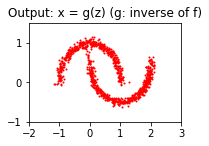

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059235
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.060050
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.058615
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.059654
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.060622
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.060142
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.058909
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.060171
====> Epoch: 8 Average train loss: -0.0597


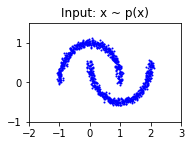

====> Test loss: -0.0612


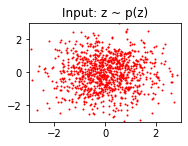

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059307
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059509
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059314
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.059405
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059524
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059321
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059314
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059199
====> Epoch: 9 Average train loss: -0.0597


====> Test loss: -0.0616


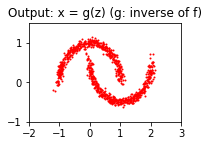

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.060050
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059136
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059771
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.059742
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059948
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059575
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.060141
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.060166
====> Epoch: 10 Average train loss: -0.0597


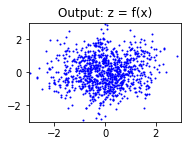

====> Test loss: -0.0614


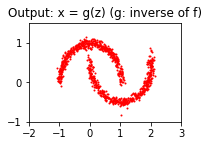

'167.75s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> Normalizing flows map the different clusters to a dense and continuous space (the gaussian space). Intuitively, when there are many clusters, each cluster is mapped to a different part of the gaussian 'blob'. This intuition is confirmed by the fact that we noticed a linear mapping between the two tails of the two moons when we plot the inverse of f.

> What it means is that there is a boundary between the two clusters that is partitioning the gaussian space. The points that are close to this boundary are somewhere in between the two moons. 
> If we extend this observation to multiple clusters, we probably could see some points that are mapped halfway between clusters.

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> GANs optimize generative tasks and gave the better results in this practical session. Nevertheless, depending on the task, GANs might not be appropriated. VAEs optimize latent modelling, the goal is to represent data in a lower dimension. Flow based model can give an estimation of the likelihood of the generated sample, which can be useful. \\
>
> Therefore each of these architectures perform better in as specific case, and the choice of the model depends on the task.